In [1]:
# import modules
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()

import re

# increasing figure dpi
import matplotlib as mpl
import nltk
import numpy as np
from keras.layers import Flatten, GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.core import Activation, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer, one_hot
from nltk.corpus import stopwords
from numpy import array, asarray, zeros
from sklearn.model_selection import train_test_split
from tensorflow import keras

mpl.rcParams["figure.dpi"] = 150

In [2]:
# read in data
txt_folder = Path("data_cs230").rglob("*.txt")
files = [x for x in txt_folder]

In [3]:
# read all files to two Python lists
filename = []
content = []
for name in files:
    # print(name)
    f = open(name, "r")
    # split name of title from extension
    f_name, f_ext = os.path.splitext(name)
    filename.append(f_name[len(f_name) - 3])
    content.append(f.readlines()[0])
    f.close()

In [4]:
# add it into dataframe
df = pd.DataFrame({"political_affiliation": filename, "speech_text": content})
df["political_affiliation"] = df["political_affiliation"].replace(
    ["D", "R"], ["Democrat", "Republican"]
)
df

,political_affiliation,speech_text
0,Republican,"mr. chairman , i am supportive , but my unders..."
1,Democrat,"mr. chairman , i yield 5 minutes to the gentle..."
2,Republican,"mr. speaker , i yield myself 2 minutes . mr. ..."
3,Democrat,"mr. speaker , the work of this subcommittee ha..."
4,Democrat,"mr. speaker , reclaiming my time , i thank aga..."
...,...,...
3824,Democrat,"mr. chairman , i demand a recorded vote ."
3825,Republican,"mr. speaker , i rise in support of s. 5 , the ..."
3826,Republican,"i appreciate the gentleman yielding to me , mr..."
3827,Republican,"mr. chairman , i move to strike the last word ..."


## Data Pre-processing

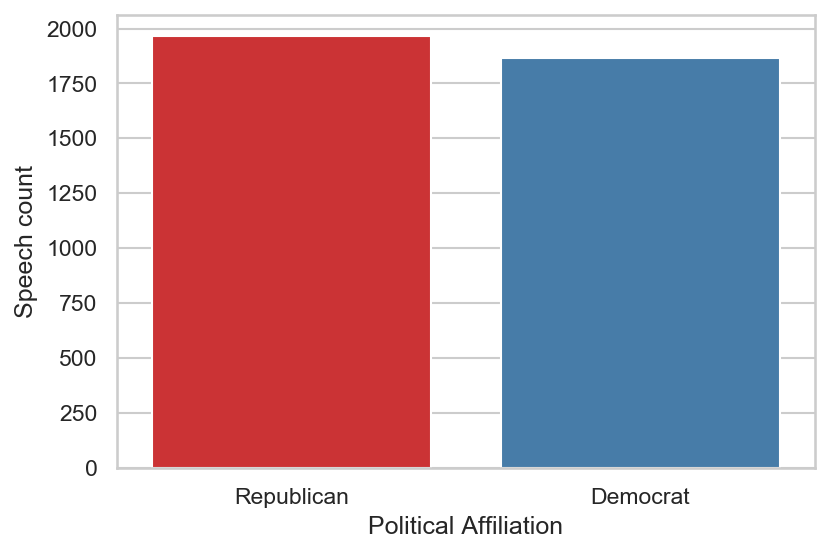

In [5]:
# descriptives
sns.set_style("whitegrid")
sns.countplot(x="political_affiliation", data=df, palette="Set1")
plt.ylabel("Speech count")
plt.xlabel("Political Affiliation")
plt.savefig("figure1.png")

In [6]:
def preprocess_text(text):
    # Remove punctuations and numbers
    text = re.sub("[^a-zA-Z]", " ", text)
    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
    # Removing multiple spaces
    text = re.sub(r"\s+", " ", text)
    return text

In [7]:
df["speech_text_clean"] = df.apply(
    lambda row: preprocess_text(row["speech_text"]), axis=1
)
df["len"] = df["speech_text_clean"].str.len()
df["len"].describe()
# median len is 931

count     3829.000000
mean      1623.861583
std       2388.123004
min          3.000000
25%        121.000000
50%        931.000000
75%       2296.000000
max      36628.000000
Name: len, dtype: float64

In [8]:
# creating a binary label for classification
# only 19 speeches for independent candidates, so clubbing them with republicans
df["republican"] = 1
df.loc[df["political_affiliation"] == "Democrat", "republican"] = 0
df

,political_affiliation,speech_text,speech_text_clean,len,republican
0,Republican,"mr. chairman , i am supportive , but my unders...",mr chairman am supportive but my understanding...,111,1
1,Democrat,"mr. chairman , i yield 5 minutes to the gentle...",mr chairman yield minutes to the gentlewoman f...,4496,0
2,Republican,"mr. speaker , i yield myself 2 minutes . mr. ...",mr speaker yield myself minutes mr speaker jus...,10041,1
3,Democrat,"mr. speaker , the work of this subcommittee ha...",mr speaker the work of this subcommittee has a...,1913,0
4,Democrat,"mr. speaker , reclaiming my time , i thank aga...",mr speaker reclaiming my time thank again the ...,1305,0
...,...,...,...,...,...
3824,Democrat,"mr. chairman , i demand a recorded vote .",mr chairman demand recorded vote,33,0
3825,Republican,"mr. speaker , i rise in support of s. 5 , the ...",mr speaker rise in support of the class action...,1914,1
3826,Republican,"i appreciate the gentleman yielding to me , mr...",i appreciate the gentleman yielding to me mr s...,363,1
3827,Republican,"mr. chairman , i move to strike the last word ...",mr chairman move to strike the last word do so...,678,1


In [9]:
X = df["speech_text_clean"]  # input
y = df["republican"]  # labels

# 75/25 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [10]:
# Preparing the embedding layer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [11]:
# Find the vocabulary size and then perform padding on both train and test set
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

In [12]:
# load the GloVe word embeddings and create a dictionary
embeddings_dictionary = dict()
glove_file = open(
    "/home/saurabh/Everything/PhD/Courses/9. Autumn 2020/CS 230/cs230/glove/glove.6B.100d.txt",
    encoding="utf8",
)

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype="float32")
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [13]:
# create embedding matrix
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Models
### Model 0: Logistic Regression (Baseline)

In [14]:
# create a sequential model
model = Sequential()
# create and add embedding layer
embedding_layer = Embedding(
    vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False
)
model.add(embedding_layer)
# adding dense layer with sigmoid activation
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))
# compile model with sgd optimizer
model.compile(optimizer="sgd", loss="binary_crossentropy", metrics=["binary_accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1875400   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 1,885,401
Trainable params: 10,001
Non-trainable params: 1,875,400
_________________________________________________________________


In [15]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.25
)

Epoch 1/50
68/68 [==============================] - 0s 3ms/step - loss: 1.0676 - binary_accuracy: 0.5044 - val_loss: 0.9773 - val_binary_accuracy: 0.4930
Epoch 2/50
68/68 [==============================] - 0s 2ms/step - loss: 0.9421 - binary_accuracy: 0.5509 - val_loss: 0.7064 - val_binary_accuracy: 0.5515
Epoch 3/50
68/68 [==============================] - 0s 3ms/step - loss: 0.8026 - binary_accuracy: 0.5945 - val_loss: 1.3627 - val_binary_accuracy: 0.5320
Epoch 4/50
68/68 [==============================] - 0s 3ms/step - loss: 0.7315 - binary_accuracy: 0.6205 - val_loss: 0.8350 - val_binary_accuracy: 0.5487
Epoch 5/50
68/68 [==============================] - 0s 3ms/step - loss: 0.6204 - binary_accuracy: 0.6716 - val_loss: 0.9261 - val_binary_accuracy: 0.5251
Epoch 6/50
68/68 [==============================] - 0s 2ms/step - loss: 0.5362 - binary_accuracy: 0.7441 - val_loss: 0.6861 - val_binary_accuracy: 0.6031
Epoch 7/50
68/68 [==============================] - 0s 3ms/step - loss: 0.48

In [16]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", score[1])

30/30 [==============================] - 0s 1ms/step - loss: 0.8593 - binary_accuracy: 0.5804
Test Accuracy: 0.5803757905960083


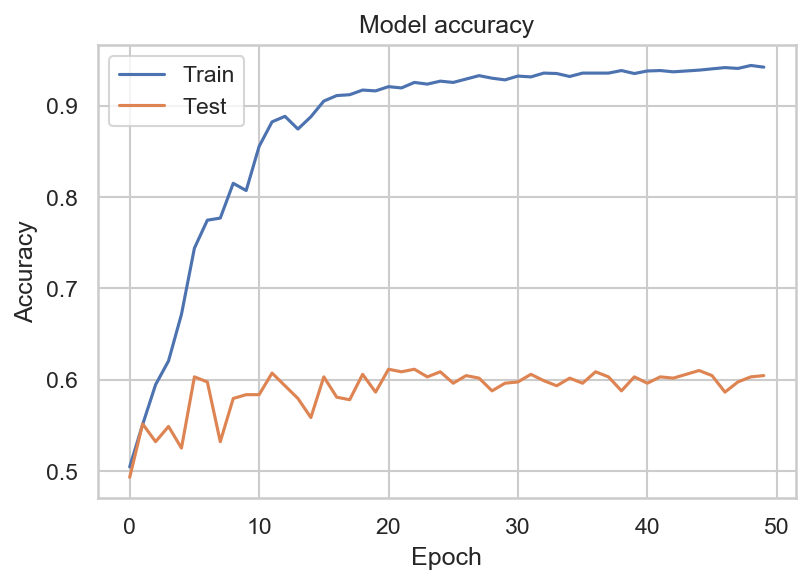

In [17]:
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.legend(["Train", "Test"], loc="upper left")
plt.savefig("figure2.png")

### Model 1: Multi-layer Perceptron

In [30]:
# create a sequential model
model = Sequential()
# create and add embedding layer
embedding_layer = Embedding(
    vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False
)
model.add(embedding_layer)
# adding dense layer with sigmoid activation
model.add(Flatten())
model.add(
    Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)
model.add(
    Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)
model.add(
    Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)
model.add(
    Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)
model.add(
    Dense(1, activation="sigmoid", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)

# compile model with adam optimizer
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1875400   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 24)                240024    
_________________________________________________________________
dense_17 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_18 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_19 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

In [31]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.25
)

Epoch 1/50
68/68 [==============================] - 0s 6ms/step - loss: 1.3445 - acc: 0.4961 - val_loss: 1.1296 - val_acc: 0.5585
Epoch 2/50
68/68 [==============================] - 0s 5ms/step - loss: 1.0313 - acc: 0.6057 - val_loss: 0.9843 - val_acc: 0.5362
Epoch 3/50
68/68 [==============================] - 0s 5ms/step - loss: 0.8979 - acc: 0.6609 - val_loss: 0.9609 - val_acc: 0.5641
Epoch 4/50
68/68 [==============================] - 0s 5ms/step - loss: 0.7296 - acc: 0.7882 - val_loss: 0.9440 - val_acc: 0.6031
Epoch 5/50
68/68 [==============================] - 0s 5ms/step - loss: 0.5761 - acc: 0.8616 - val_loss: 1.1111 - val_acc: 0.5766
Epoch 6/50
68/68 [==============================] - 0s 5ms/step - loss: 0.4741 - acc: 0.9025 - val_loss: 1.2028 - val_acc: 0.5919
Epoch 7/50
68/68 [==============================] - 0s 6ms/step - loss: 0.4116 - acc: 0.9210 - val_loss: 1.4305 - val_acc: 0.5808
Epoch 8/50
68/68 [==============================] - 0s 5ms/step - loss: 0.4449 - acc: 0.89

In [20]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", score[1])

30/30 [==============================] - 0s 2ms/step - loss: 1.5717 - acc: 0.5511
Test Accuracy: 0.5511482357978821


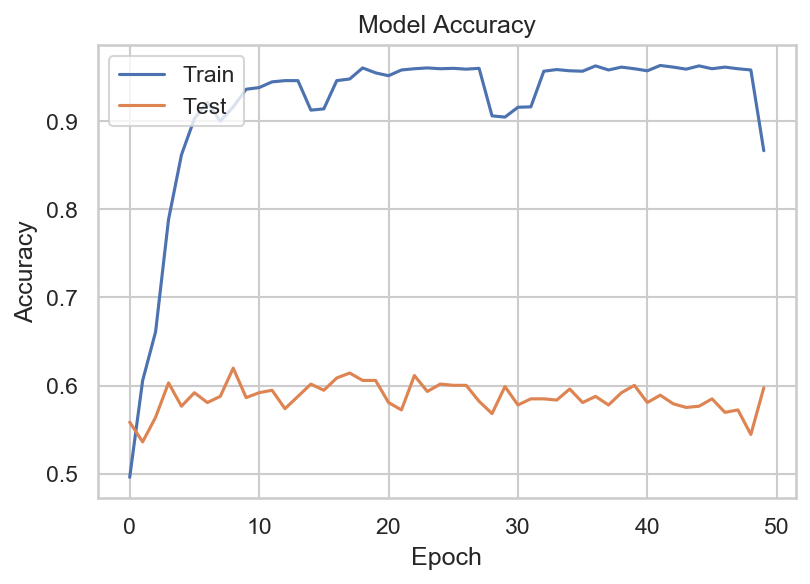

In [32]:
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.legend(["Train", "Test"], loc="upper left")
plt.savefig("figure3.png")

### Model 2: Convolutional Neural Net

In [22]:
model = Sequential()

embedding_layer = Embedding(
    vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False
)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(
    Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)
model.add(
    Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)
model.add(
    Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)
model.add(
    Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1875400   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_7 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_8 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_9 (Dense)              (None, 24)               

In [23]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.25
)

Epoch 1/50
68/68 [==============================] - 1s 17ms/step - loss: 1.3755 - acc: 0.5221 - val_loss: 1.2149 - val_acc: 0.5097
Epoch 2/50
68/68 [==============================] - 1s 15ms/step - loss: 1.0989 - acc: 0.5662 - val_loss: 0.9946 - val_acc: 0.6337
Epoch 3/50
68/68 [==============================] - 1s 14ms/step - loss: 0.8912 - acc: 0.6846 - val_loss: 0.8860 - val_acc: 0.5864
Epoch 4/50
68/68 [==============================] - 1s 13ms/step - loss: 0.7298 - acc: 0.7589 - val_loss: 0.8049 - val_acc: 0.6379
Epoch 5/50
68/68 [==============================] - 1s 18ms/step - loss: 0.5305 - acc: 0.8602 - val_loss: 0.8463 - val_acc: 0.6574
Epoch 6/50
68/68 [==============================] - 1s 14ms/step - loss: 0.3727 - acc: 0.9285 - val_loss: 1.0078 - val_acc: 0.6323
Epoch 7/50
68/68 [==============================] - 1s 15ms/step - loss: 0.3160 - acc: 0.9424 - val_loss: 0.8753 - val_acc: 0.6783
Epoch 8/50
68/68 [==============================] - 1s 16ms/step - loss: 0.2649 - a

In [24]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", score[1])

30/30 [==============================] - 0s 5ms/step - loss: 0.8499 - acc: 0.6545
Test Accuracy: 0.6544885039329529


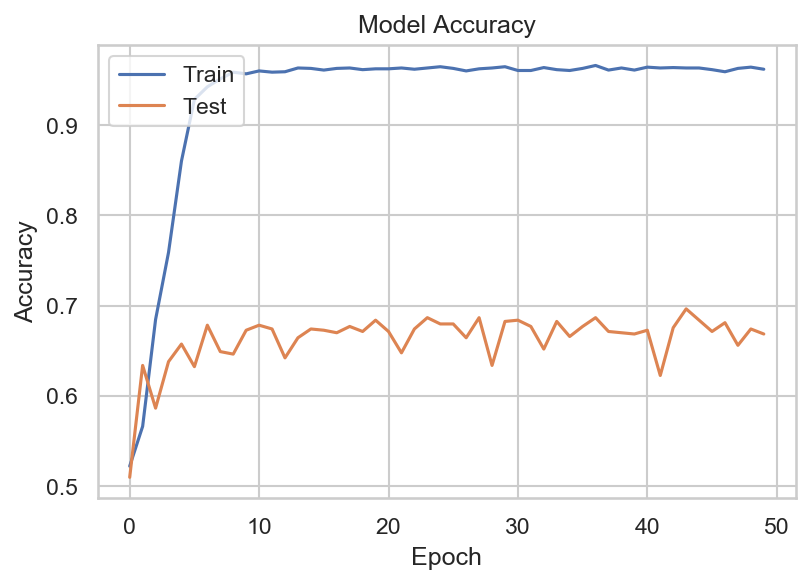

In [25]:
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.legend(["Train", "Test"], loc="upper left")
plt.savefig("figure4.png")

### Model 3: LSTM-RNN

In [26]:
model = Sequential()
embedding_layer = Embedding(
    vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False
)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(24, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(24, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(24, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(24, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1875400   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_11 (Dense)             (None, 24)                3096      
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 24)                600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 24)               

In [27]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=80, verbose=1, validation_split=0.25
)

Epoch 1/80
68/68 [==============================] - 6s 95ms/step - loss: 0.6952 - acc: 0.5067 - val_loss: 0.6932 - val_acc: 0.4972
Epoch 2/80
68/68 [==============================] - 6s 84ms/step - loss: 0.6938 - acc: 0.5063 - val_loss: 0.6932 - val_acc: 0.4958
Epoch 3/80
68/68 [==============================] - 6s 88ms/step - loss: 0.6910 - acc: 0.5314 - val_loss: 0.6957 - val_acc: 0.4958
Epoch 4/80
68/68 [==============================] - 5s 81ms/step - loss: 0.6942 - acc: 0.5086 - val_loss: 0.6918 - val_acc: 0.5376
Epoch 5/80
68/68 [==============================] - 6s 93ms/step - loss: 0.6920 - acc: 0.5225 - val_loss: 0.6918 - val_acc: 0.5167
Epoch 6/80
68/68 [==============================] - 6s 91ms/step - loss: 0.6924 - acc: 0.5239 - val_loss: 0.6915 - val_acc: 0.5292
Epoch 7/80
68/68 [==============================] - 6s 93ms/step - loss: 0.6887 - acc: 0.5462 - val_loss: 0.6890 - val_acc: 0.5376
Epoch 8/80
68/68 [==============================] - 5s 81ms/step - loss: 0.6899 - a

In [28]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", score[1])

30/30 [==============================] - 1s 27ms/step - loss: 3.1599 - acc: 0.5720
Test Accuracy: 0.5720250606536865


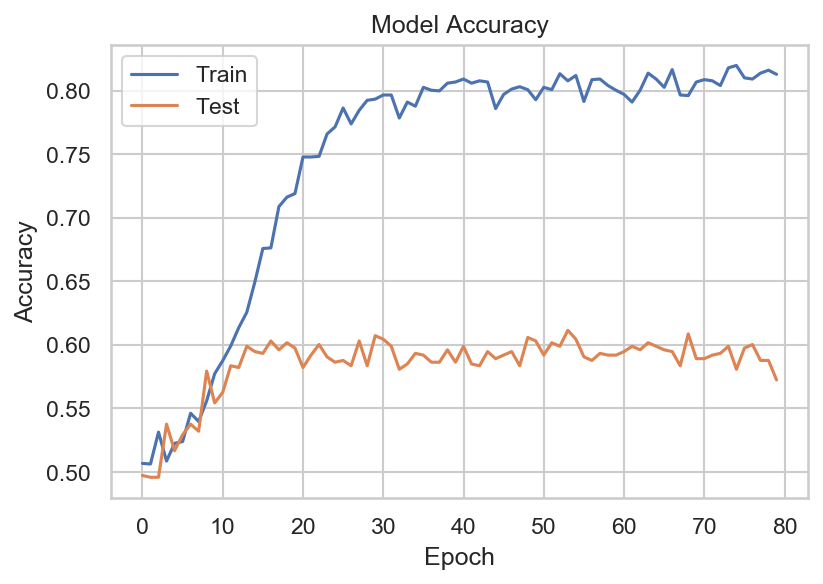

In [29]:
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.legend(["Train", "Test"], loc="upper left")
plt.savefig("figure5.png")